In [1]:
from network_evaluation_tools import gene_conversion_tools as gct
from network_evaluation_tools import data_import_tools as dit
import pandas as pd
import time
import matplotlib.pyplot as plt

In [2]:
wd = '/cellar/users/snwright/Data/Network_Analysis/'

# Version 2.0
## Load IntAct Raw Data
**Source (PSI-MITAB): ftp://ftp.ebi.ac.uk/pub/databases/intact/current/psimitab/intact.txt**  
Downloaded: Dec 8, 2021   
Last Updated: Updated monthly  
Notes for processing: All interactions listed here need to be filtered for human-human interactions. Given the size of the file, we will filter the interactions and save the human-only interactions to a separate file to be loaded to save memory.

In [3]:
input_raw_v2 = pd.read_csv(wd+'Network_Data_Raw/IntAct/2021-12-00_intact.txt.gz', sep='\t')
print('Raw edge count in IntAct_v2:', len(input_raw_v2))

Raw edge count in IntAct_v2: 1155104


## Input Processing

In [4]:
# Columns are the same as the previous dataset
input_raw_v2.columns

Index(['#ID(s) interactor A', 'ID(s) interactor B', 'Alt. ID(s) interactor A',
       'Alt. ID(s) interactor B', 'Alias(es) interactor A',
       'Alias(es) interactor B', 'Interaction detection method(s)',
       'Publication 1st author(s)', 'Publication Identifier(s)',
       'Taxid interactor A', 'Taxid interactor B', 'Interaction type(s)',
       'Source database(s)', 'Interaction identifier(s)',
       'Confidence value(s)', 'Expansion method(s)',
       'Biological role(s) interactor A', 'Biological role(s) interactor B',
       'Experimental role(s) interactor A',
       'Experimental role(s) interactor B', 'Type(s) interactor A',
       'Type(s) interactor B', 'Xref(s) interactor A', 'Xref(s) interactor B',
       'Interaction Xref(s)', 'Annotation(s) interactor A',
       'Annotation(s) interactor B', 'Interaction annotation(s)',
       'Host organism(s)', 'Interaction parameter(s)', 'Creation date',
       'Update date', 'Checksum(s) interactor A', 'Checksum(s) interactor B',

### Keep only human-human interactions

In [5]:
# Filter  for only human-human interactions in IntAct
input_human_v2 = input_raw_v2[(input_raw_v2['Taxid interactor A']=='taxid:9606(human)|taxid:9606(Homo sapiens)') & (input_raw_v2['Taxid interactor B']=='taxid:9606(human)|taxid:9606(Homo sapiens)')]
input_human_v2 = input_human_v2.drop_duplicates()
print('Human-Human only edge count in IntAct_v2:', input_human_v2.shape[0])

Human-Human only edge count in IntAct_v2: 598815


In [6]:
genes_v2 = list(set(input_human_v2['#ID(s) interactor A']).union(set(input_human_v2['ID(s) interactor B'])))

## Convert Genes

In [8]:
# Construct list of genes to be submitted to MyGene.Info API (remove all genes with 'intact' prefix)
query_string_v2, valid_genes_v2, invalid_genes_v2 = gct.query_constructor(genes_v2, exclude_prefixes=['intact'])

28262 Valid Query Genes
2152 Invalid Query Genes


### Map from isoforms to uniprot ID

In [10]:
uniprot_ids_v2, missing_v2 = gct.query_uniprot(valid_genes_v2, return_as_dict=False, target_fmt="ACC")

In [24]:
uniprot_query_v2, valid_uniprot_v2, invalid_uniprot_v2 = gct.query_constructor(uniprot_ids_v2["ACC"].tolist() + missing_v2)

28280 Valid Query Genes
0 Invalid Query Genes


### Map to gene symbols

In [31]:
# Set scopes (gene naming systems to search)
scopes = "uniprot, ensemblgene"

# Set fields (systems from which to return gene names from)
fields = "symbol, entrezgene"

# Query MyGene.Info
match_list_v2 = gct.query_batch(uniprot_query_v2, scopes=scopes, fields=fields)


100%|██████████| 29/29 [00:23<00:00,  1.26it/s]

28640 Matched query results
Batch query complete: 23.02 seconds


In [32]:
match_list_v2 = pd.DataFrame.from_dict(match_list_v2)

In [33]:
match_list_v2.loc[match_list_v2.notfound==True]

,query,_id,_score,entrezgene,symbol,notfound
5,A4ZVS7,NaN,NaN,NaN,NaN,True
8,B2RDY9,NaN,NaN,NaN,NaN,True
23,Q17RD9,NaN,NaN,NaN,NaN,True
29,Q86TH3,NaN,NaN,NaN,NaN,True
33,A8K5T7,NaN,NaN,NaN,NaN,True
...,...,...,...,...,...,...
28616,Q15582-PRO_0000008769,NaN,NaN,NaN,NaN,True
28619,P46531-PRO_0000007676,NaN,NaN,NaN,NaN,True
28620,P05067-PRO_0000000088,NaN,NaN,NaN,NaN,True
28627,P05814-PRO_0000004475,NaN,NaN,NaN,NaN,True


In [34]:
match_table_trim_v2, query_to_symbol_v2, query_to_entrez_v2 = gct.construct_query_map_table(match_list_v2, valid_uniprot_v2)

Number of genes with multiple matches: 6948
Number of unmatched genes: 2038
Number of fully matched genes: 19609
Number of partially matched genes: 2083


## Construct Converted Network

In [37]:
edgelist_v2 = input_human_v2[['#ID(s) interactor A', 'ID(s) interactor B']].drop_duplicates().values.tolist()

In [44]:
# Original = 5864/161035
# Filter query edgelist of interactions with invalid genes
edgelist_v2 = gct.filter_query_edgelist(edgelist_v2, invalid_genes_v2)


11362 / 360056 edges with invalid nodes removed


In [45]:
# Format edge list by removing 'uniprot:' prefix from all interactors
edgelist_v2 = [[gct.get_identifier_without_prefix(edge[0]), gct.get_identifier_without_prefix(edge[1])] for edge in edgelist_v2]

In [46]:
# Convert network edge list to symbol
edgelist_updated_v2 = gct.convert_edgelist(edgelist_v2, query_to_symbol_v2)

In [47]:
# Filter converted edge list
edgelist_filt_v2 = gct.filter_converted_edgelist(edgelist_updated_v2)

348694 input edges
2178 self-edges removed
80033 edges with un-mapped genes removed
35851 duplicate edges removed
Edge list filtered: 0.14 seconds
230632 Edges remaining


In [48]:
# Save filtered, converted edge list to file
gct.write_edgelist(edgelist_filt_v2, wd+'/Processed_Data/Network_SIFs_Symbol/IntAct_Symbol_2021.sif')

Edge list saved: 0.35 seconds


# Version 1.0 (Original)
## Load IntAct Raw Data
**Source (PSI-MITAB): ftp://ftp.ebi.ac.uk/pub/databases/intact/current/psimitab/intact.txt**  
Downloaded: June 15, 2017   
Last Updated: June 05, 2017  
Notes for processing: All interactions listed here need to be filtered for human-human interactions. Given the size of the file, we will filter the interactions and save the human-only interactions to a separate file to be loaded to save memory.

In [50]:
input_raw = pd.read_csv(wd+'Network_Data_Raw/IntAct/2016-09-08_intact.txt.gz', sep='\t', low_memory=False)
print('Raw edge count in IntAct:', len(input_raw))

Raw edge count in IntAct: 653104


## Custom Processing of Raw DIP Data

#### Keep only human-human interactions

In [51]:
# Filter  for only human-human interactions in IntAct
input_human = input_raw[(input_raw['Taxid interactor A']=='taxid:9606(human)|taxid:9606(Homo sapiens)') & (input_raw['Taxid interactor B']=='taxid:9606(human)|taxid:9606(Homo sapiens)')]
input_human = input_human.drop_duplicates()
print('Human-Human only edge count in IntAct:', input_human.shape[0])

Human-Human only edge count in IntAct: 247565


In [52]:
genes = list(set(input_human['#ID(s) interactor A']).union(set(input_human['ID(s) interactor B'])))

## Convert Genes

In [53]:
# Construct list of genes to be submitted to MyGene.Info API (remove all genes with 'intact' prefix)
query_string, valid_genes, invalid_genes = gct.query_constructor(genes, exclude_prefixes=['intact'])

19143 Valid Query Genes
1162 Invalid Query Genes


### Map isoforms to uniprot

In [57]:
uniprot_ids, missing = gct.query_uniprot(valid_genes, return_as_dict=False, target_fmt="ACC")

In [58]:
uniprot_query, valid_uniprot, invalid_uniprot = gct.query_constructor(uniprot_ids["ACC"].tolist() + missing_v2)

19474 Valid Query Genes
0 Invalid Query Genes


### Map to gene symbols

In [60]:
# Original 19368 matched query results
# Set scopes (gene naming systems to search)
scopes = "uniprot, ensemblgene"

# Set fields (systems from which to return gene names from)
fields = "symbol, entrezgene"

# Query MyGene.Info
match_list = gct.query_batch(uniprot_query, scopes=scopes, fields=fields)
print(len(match_list), 'Matched query results')

100%|██████████| 20/20 [00:16<00:00,  1.23it/s]

19717 Matched query results
Batch query complete: 16.2 seconds
19717 Matched query results


In [61]:
match_list = pd.DataFrame.from_dict(match_list)

In [62]:
#Original unmatched = 4329

match_table_trim, query_to_symbol, query_to_entrez = gct.construct_query_map_table(match_list, valid_uniprot)

Number of genes with multiple matches: 2911
Number of unmatched genes: 1240
Number of fully matched genes: 15538
Number of partially matched genes: 1268


## Construct Converted Network

In [63]:
edgelist = input_human[['#ID(s) interactor A', 'ID(s) interactor B']].drop_duplicates().values.tolist()

In [64]:
# Original = 5864/161035
# Filter query edgelist of interactions with invalid genes
edgelist = gct.filter_query_edgelist(edgelist, invalid_genes)


5864 / 161035 edges with invalid nodes removed


In [65]:
# Format edge list by removing 'uniprot:' prefix from all interactors
edgelist = [[gct.get_identifier_without_prefix(edge[0]), gct.get_identifier_without_prefix(edge[1])] for edge in edgelist]

In [66]:
# Convert network edge list to symbol
edgelist_updated = gct.convert_edgelist(edgelist, query_to_symbol)

In [67]:
## Original stats##
#155171 input edges
#3236 self-edges removed
#20662 edges with un-mapped genes removed
#16701 duplicate edges removed
#Edge list filtered: 0.43 seconds
#114572 Edges remaining

# Filter converted edge list
edgelist_filt = gct.filter_converted_edgelist(edgelist_updated)

155171 input edges
1571 self-edges removed
22022 edges with un-mapped genes removed
16812 duplicate edges removed
Edge list filtered: 0.07 seconds
114766 Edges remaining


In [68]:
# Save filtered, converted edge list to file
gct.write_edgelist(edgelist_filt, wd+'/Processed_Data/Network_SIFs_Symbol/IntAct_Symbol_2016.sif')

Edge list saved: 0.19 seconds


# Changes
* No changes identified in structure of data
* Minor changes when re-running the original dataset due to updated symbol database being queried

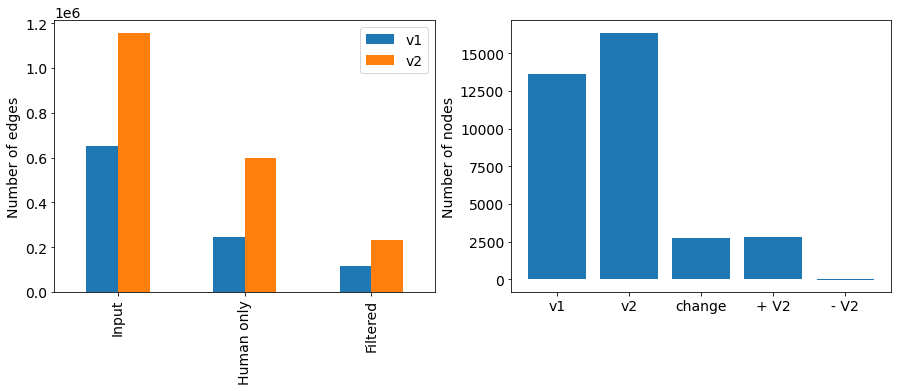

In [71]:
dit.plot_changes_to_dataset(input_raw, input_raw_v2, edgelist_filt, edgelist_filt_v2, input_human, input_human_v2)